<a href="https://colab.research.google.com/github/willcoomans5/mlb_predictions/blob/main/mlb_game_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# import os, sys
# nb_path = '/content/notebooks'
# os.symlink('/content/drive/MyDrive/Colab Notebooks', nb_path)
# sys.path.insert(0,nb_path)

In [3]:
!pip3 install torch torchvision ray torchaudio pybaseball scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 32.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manyli

In [114]:
import os
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import *
import numpy as np
import pybaseball as pyb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

from datetime import date
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split



pyb.cache.enable()
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)


In [79]:
path = '/content/drive/MyDrive/mlbpredictions/'

In [ ]:
statcast_data = pyb.statcast(start_dt='2023-03-28', end_dt='2023-11-01')

This is a large query, it may take a moment to complete


100%|██████████| 219/219 [05:54<00:00,  1.62s/it]


In [ ]:
print(statcast_data.shape)
statcast_data.to_csv(path + "statcast_2023.csv")

NameError: name 'statcast_data' is not defined

In [6]:
# Interesting Features:
# use release_spin_rate, spin_axis, vx0, vy0, vz0, pfx_x, pfx_z
# maybe release_extension, release_pos_x, release_pos_z

In [81]:
sc = pd.read_csv(path + "statcast_2023.csv")
# data = sc.sample(200000, random_state=42)
data = sc

In [82]:
features = ['release_spin_rate', 'release_speed', 'release_extension',
            'release_pos_x', 'release_pos_z', 'spin_axis', 'vx0', 'vy0',
            'vz0', 'pfx_x', 'pfx_z', 'p_throws', 'balls', 'strikes']

target = 'pitch_name'
data = data[features + [target]]
X = data.drop(columns=["pitch_name"])
y = data["pitch_name"]

train_valid, test = train_test_split(data, test_size=0.2, random_state=42)
train, valid = train_test_split(train_valid, test_size=0.2, random_state=42)
print(train.shape)
print(valid.shape)
print(test.shape)

(468597, 15)
(117150, 15)
(146437, 15)


In [83]:
print(train["pitch_name"].value_counts())
print("\n")
print(train.isnull().sum())

pitch_name
4-Seam Fastball    151550
Slider              79208
Sinker              71427
Changeup            50938
Cutter              36511
Curveball           32048
Sweeper             23400
Split-Finger        10498
Knuckle Curve        9263
Slurve               1610
Other                 690
Forkball              504
Eephus                354
Knuckleball           130
Screwball              47
Slow Curve             31
Pitch Out              30
Name: count, dtype: int64


release_spin_rate    2885
release_speed         357
release_extension    1028
release_pos_x         357
release_pos_z         357
spin_axis            2885
vx0                   357
vy0                   357
vz0                   357
pfx_x                 357
pfx_z                 357
p_throws                0
balls                   0
strikes                 0
pitch_name            358
dtype: int64


Only 103 out of our 128000 training samples have missing dependent values. As shown above, these data points appear to be insignificant, as most of the remaining features have missing values as well. Consequently, removing these 103 rows is justified.

Below, we will handle the rest of the missing values appropriately. We will also one hot encode our "p_throws" column.



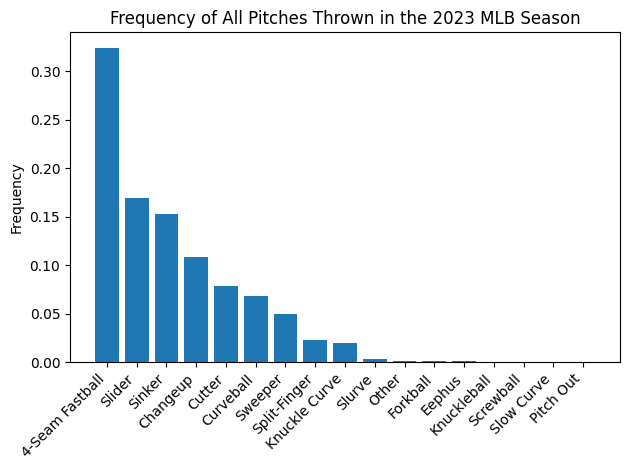

In [84]:
def remove_target_null(data):
  data = data[~data["pitch_name"].isnull()]
  return data

train = remove_target_null(train)

freq = train["pitch_name"].value_counts() / len(train)
plt.bar(x=freq.index, height=freq)
plt.xticks(rotation=45, ha='right')
plt.title("Frequency of All Pitches Thrown in the 2023 MLB Season")
plt.ylabel("Frequency")
plt.tight_layout()

In [85]:
# Map right handed pitchers to the value 1 and left handed pitchers to the value 0

def p_throws_ohe(data):
  mapping_dict = {"L": 0, "R": 1}

  # Check for existing numerical values and map only non-numerical values
  if type(data['p_throws'].iloc[0]) == str:
    data['p_throws'] = data['p_throws'].map(mapping_dict)
  return data


# Display the result
train = p_throws_ohe(train)
train.head()

,release_spin_rate,release_speed,release_extension,release_pos_x,release_pos_z,spin_axis,vx0,vy0,vz0,pfx_x,pfx_z,p_throws,balls,strikes,pitch_name
216099,1834.0,80.1,6.6,2.12,6.12,88.0,-8.177792,-115.872190,-8.426228,0.20,0.30,0,1,2,Slider
355273,2464.0,85.3,6.5,-1.98,6.47,72.0,5.459679,-124.035560,-8.254411,0.24,-0.06,1,1,2,Slider
444450,2582.0,84.4,6.2,-3.07,5.39,61.0,5.008387,-122.889500,-0.545208,0.85,-0.55,1,1,0,Slider
458053,1980.0,92.4,6.5,-1.30,5.55,226.0,8.337798,-134.220267,-5.483424,-1.55,0.62,1,0,0,Sinker
7451,2338.0,96.3,6.9,-2.02,6.33,220.0,5.144830,-140.020941,-6.430641,-0.72,1.12,1,3,2,4-Seam Fastball


Let's visualize some of the distributions of our features

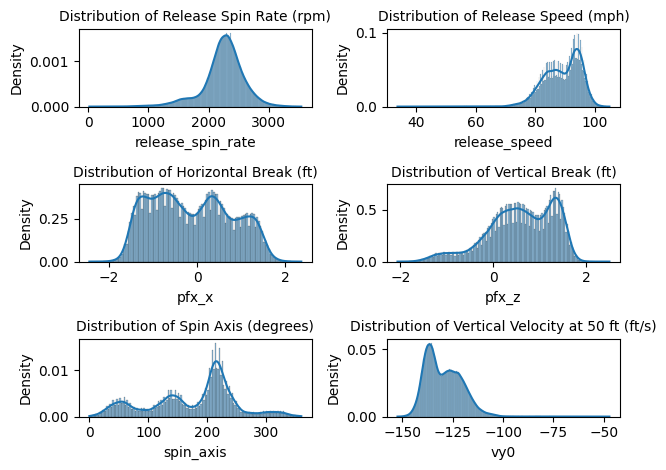

In [86]:
fig, ax = plt.subplots(3, 2)

sns.histplot(data=train, x="release_spin_rate", stat='density', kde=True, ax=ax[0, 0])
ax[0, 0].set_title("Distribution of Release Spin Rate (rpm)", fontsize=10)

sns.histplot(data=train, x="release_speed", stat='density', kde=True, ax=ax[0, 1])
ax[0, 1].set_title("Distribution of Release Speed (mph)", fontsize=10)

sns.histplot(data=train, x="pfx_x", stat='density', kde=True, ax=ax[1, 0])
ax[1, 0].set_title("Distribution of Horizontal Break (ft)", fontsize=10)

sns.histplot(data=train, x="pfx_z", stat='density', kde=True, ax=ax[1, 1])
ax[1, 1].set_title("Distribution of Vertical Break (ft)", fontsize=10)

sns.histplot(data=train, x="spin_axis", stat='density', kde=True, ax=ax[2, 0])
ax[2, 0].set_title("Distribution of Spin Axis (degrees)", fontsize=10)

sns.histplot(data=train, x="vy0", stat='density', kde=True, ax=ax[2, 1])
ax[2, 1].set_title("Distribution of Vertical Velocity at 50 ft (ft/s)", fontsize=10)


plt.tight_layout()
plt.show()

In [87]:
def fill_vals(data):
  data['release_spin_rate'] = data['release_spin_rate'].fillna(data['release_spin_rate'].mean())
  data['release_speed'] = data['release_speed'].fillna(data['release_speed'].mean())
  data['release_extension'] = data['release_extension'].fillna(data['release_extension'].mean())
  data['release_extension'] = data['release_extension'].fillna(data['release_extension'].mean())
  data['release_pos_x'] = data['release_pos_x'].fillna(data['release_pos_x'].mode()[0])
  data['release_pos_z'] = data['release_pos_z'].fillna(data['release_pos_z'].mean())
  data['spin_axis'] = data['spin_axis'].fillna(data['spin_axis'].mode()[0])
  data['pfx_x'] = data['pfx_x'].fillna(data['pfx_x'].mean())
  data['pfx_z'] = data['pfx_z'].fillna(data['pfx_z'].mean())
  data['vx0'] = data['vx0'].fillna(data['vx0'].mean())
  data['vy0'] = data['vy0'].fillna(data['vy0'].mean())
  data['vz0'] = data['vz0'].fillna(data['vz0'].mean())
  return data

train = fill_vals(train)
print(train.isnull().sum())

release_spin_rate    0
release_speed        0
release_extension    0
release_pos_x        0
release_pos_z        0
spin_axis            0
vx0                  0
vy0                  0
vz0                  0
pfx_x                0
pfx_z                0
p_throws             0
balls                0
strikes              0
pitch_name           0
dtype: int64


In [88]:
def label_encode(data):
  le = LabelEncoder()
  le.fit(data['pitch_name'])
  data['pitch_name'] = le.transform(data['pitch_name'])
  return data, le

train, le = label_encode(train)
for idx, label in enumerate(le.classes_):
  print(f"label: {label}, encoding: {idx}")

label: 4-Seam Fastball, encoding: 0
label: Changeup, encoding: 1
label: Curveball, encoding: 2
label: Cutter, encoding: 3
label: Eephus, encoding: 4
label: Forkball, encoding: 5
label: Knuckle Curve, encoding: 6
label: Knuckleball, encoding: 7
label: Other, encoding: 8
label: Pitch Out, encoding: 9
label: Screwball, encoding: 10
label: Sinker, encoding: 11
label: Slider, encoding: 12
label: Slow Curve, encoding: 13
label: Slurve, encoding: 14
label: Split-Finger, encoding: 15
label: Sweeper, encoding: 16


In [89]:
def normalize(data):
  cols = ['release_spin_rate', 'release_speed', 'release_extension',
            'release_pos_x', 'release_pos_z', 'spin_axis', 'vx0', 'vy0',
            'vz0', 'pfx_x', 'pfx_z', 'balls', 'strikes']

  df = data.copy()[cols]
  data.loc[:, cols] = (df - df.min()) / (df.max() - df.min())
  return data

train = normalize(train)
train

,release_spin_rate,release_speed,release_extension,release_pos_x,release_pos_z,spin_axis,vx0,vy0,vz0,pfx_x,pfx_z,p_throws,balls,strikes,pitch_name
216099,0.515306,0.652602,0.413793,0.727557,0.794074,0.244444,0.312963,0.346991,0.324834,0.550000,0.517544,0,0.25,1.0,12
355273,0.693878,0.725738,0.402299,0.299582,0.845926,0.200000,0.647717,0.269300,0.329641,0.558333,0.438596,1,0.25,1.0,12
444450,0.727324,0.713080,0.367816,0.185804,0.685926,0.169444,0.636639,0.280207,0.545317,0.685417,0.331140,1,0.25,0.0,12
458053,0.556689,0.825598,0.402299,0.370564,0.709630,0.627778,0.718365,0.172371,0.407163,0.185417,0.587719,1,0.00,0.0,11
7451,0.658163,0.880450,0.448276,0.295407,0.825185,0.611111,0.639988,0.117166,0.380663,0.358333,0.697368,1,0.75,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19607,0.659580,0.704641,0.310345,0.488518,0.850370,0.544444,0.525011,0.290187,0.385922,0.522917,0.508772,1,0.50,1.0,12
51153,0.599773,0.845288,0.425287,0.295407,0.703704,0.577778,0.617569,0.150875,0.477920,0.233333,0.671053,1,0.50,0.5,11
672799,0.578515,0.589311,0.482759,0.618998,0.749630,0.866667,0.472648,0.401840,0.596217,0.377083,0.276316,0,0.50,0.5,2
559700,0.633503,0.877637,0.425287,0.716075,0.780741,0.388889,0.249168,0.123455,0.348428,0.743750,0.638158,0,0.75,0.0,0


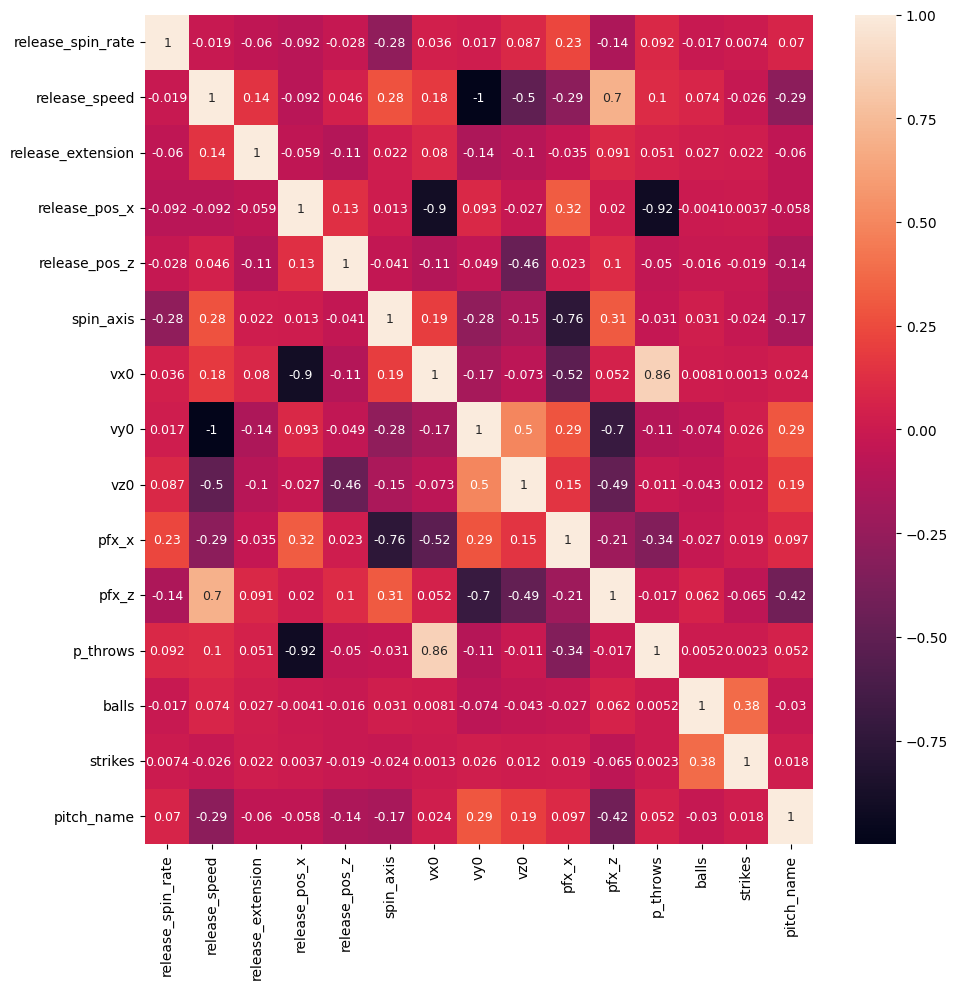

In [90]:
corr_data = train[features + [target]].corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(data=corr_data, annot=True, annot_kws={"size": 9})
plt.tight_layout()

In [91]:
def pipeline(data):
  df = data.copy()
  df = remove_target_null(df)
  df = p_throws_ohe(df)
  df = fill_vals(df)
  df = label_encode(df)[0]
  df = normalize(df)
  y = torch.tensor(df["pitch_name"].values, dtype=torch.long)
  X = torch.tensor(df.drop(columns=["pitch_name"]).values, dtype=torch.float32)
  return X, y

X_train, Y_train = pipeline(train)
X_valid, Y_valid = pipeline(valid)
X_test, Y_test = pipeline(test)


In [102]:
class CustomMLBDataSet(Dataset):
  def __init__(self, features, targets):
    self.features = features
    self.targets = targets

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    sample = self.features[idx], self.targets[idx]
    return sample

train_dataset = CustomMLBDataSet(X_train, Y_train)
valid_dataset = CustomMLBDataSet(X_valid, Y_valid)
test_dataset = CustomMLBDataSet(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [103]:
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')

Feature batch shape: torch.Size([32, 14])
Labels batch shape: torch.Size([32])


In [104]:
class SoftmaxRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(14, 17, bias=True)

  def forward(self, x):
    logits = self.linear(x)
    return logits

  def pred_labels(self, logits):
    probs = nn.Softmax(dim=1)(logits)
    return torch.argmax(probs, dim=1)

In [137]:
def train_model(model, dataloader, epochs, lr, momentum):
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  loss_fn = nn.CrossEntropyLoss()
  num_rows = len(dataloader.dataset)
  model.train()

  # Writer will output to ./runs/ directory by default
  writer = SummaryWriter()


  for epoch in range(epochs):
    running_loss = 0
    for idx, data in enumerate(train_dataloader):
      features, labels = data

      # Each "features" has 64 samples, a tensor with dimensions (16, 14)
      # Each "labels" has 64 samples with, a tensor with dimensions(16, 1)
      features = features.to(device)
      labels = labels.to(device)

      # Feedforward the features to get our predictions from the neural network.
      logits = model.forward(features)

      # Reset the gradients to zero since gradients accumulate with each call to backward()
      optimizer.zero_grad()

      # Compute the Cross Entropy Loss between our predictions and our true labels.
      # nn.CrossEntropyLoss() internally applies nn.LogSoftmax() and nn.NLLLoss()
      loss = loss_fn(logits, labels)

      # Compute the gradient of the loss function (cross-entropy) with respect to each parameter
      loss.backward()

      # Update the parameters with stochastic gradient descent
      optimizer.step()

      running_loss += loss.item()

    avg_loss = running_loss / num_rows
    writer.add_scalar("Loss/train", avg_loss, epoch + 1)
    print(f'EPOCH: {epoch + 1}\n=============')
    print(f'Average Loss: {avg_loss}\n')
  writer.flush()

def test_accuracy(model, dataloader, loss_fn):
  total_loss = 0
  correct = 0
  num_rows = len(dataloader.dataset)
  model.eval()

  # Writer will output to ./runs/ directory by default
  writer = SummaryWriter()

  with torch.no_grad():
    for i, data in enumerate(dataloader):
      features, labels = data
      features = features.to(device)
      labels = labels.to(device)

      logits = model.forward(features)
      preds = model.pred_labels(logits)

      total_loss += loss_fn(logits, labels).item()
      correct += torch.sum(preds == labels).item()

  accuracy = 100 * correct / num_rows
  avg_loss = total_loss / num_rows
  print(f'Average Loss: {avg_loss}')
  print(f'Accuracy: {accuracy}')

  return accuracy, avg_loss



In [138]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'GPU device name: {torch.cuda.get_device_name(device)}')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

model = SoftmaxRegression().to(device)
print(model)

No GPU available, using the CPU instead.
SoftmaxRegression(
  (linear): Linear(in_features=14, out_features=17, bias=True)
)


In [139]:
ex_data = torch.rand(2, 14, device=device)


logits = model(ex_data)
print(logits)

# performs softmax along the columns, i.e. the sum of the columns is 1
proba = nn.Softmax(dim=1)(logits)
print(proba)


print(torch.argmax(proba, dim=1))

tensor([[-0.1710, -0.2627,  0.0340, -0.0607,  0.3166, -0.5940, -0.0661,  0.1439,
          0.1643, -0.8918, -0.1153, -0.9366, -0.1399, -0.1132,  0.2039,  0.3295,
         -0.6800],
        [ 0.3402, -0.2586,  0.1658, -0.0781,  0.4604, -0.4393,  0.0283,  0.4843,
          0.1604, -0.4797, -0.0081, -0.5933, -0.4896, -0.1988, -0.0130,  0.0273,
         -0.9507]], grad_fn=<AddmmBackward0>)
tensor([[0.0549, 0.0501, 0.0674, 0.0613, 0.0894, 0.0359, 0.0609, 0.0752, 0.0767,
         0.0267, 0.0580, 0.0255, 0.0566, 0.0581, 0.0798, 0.0905, 0.0330],
        [0.0860, 0.0473, 0.0723, 0.0566, 0.0970, 0.0395, 0.0630, 0.0994, 0.0719,
         0.0379, 0.0607, 0.0338, 0.0375, 0.0502, 0.0604, 0.0629, 0.0237]],
       grad_fn=<SoftmaxBackward0>)
tensor([15,  7])


In [140]:
epochs = 10
lr = 0.001
momentum = 0.9

train_model(model, train_dataloader, epochs, lr, momentum)

EPOCH: 1
Average Loss: 0.05246139415082542

EPOCH: 2
Average Loss: 0.04388827928393848

EPOCH: 3
Average Loss: 0.04016701370503963

EPOCH: 4
Average Loss: 0.03775943242003955

EPOCH: 5
Average Loss: 0.036022014863767965

EPOCH: 6
Average Loss: 0.03468741387992338

EPOCH: 7
Average Loss: 0.03362241006747804

EPOCH: 8
Average Loss: 0.032744654273262966

EPOCH: 9
Average Loss: 0.03200588319544378

EPOCH: 10
Average Loss: 0.0313734383274342



In [128]:
print('Training Set:')
test_accuracy(model, train_dataloader, nn.CrossEntropyLoss())
print('\nValidation Set:')
test_accuracy(model, valid_dataloader, nn.CrossEntropyLoss())

Training Set:
Average Loss: 0.031077688778658775
Accuracy: 67.94927376831063

Validation Set:
Average Loss: 0.03130587055817881
Accuracy: 66.22274994874599


(66.22274994874599, 0.03130587055817881)

In [142]:
# !pip install tensorboard
!tensorboard --logdir runs --bind_all --port 6007

2024-07-21 02:09:02.963063: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 02:09:02.963146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 02:09:02.964646: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 02:09:04.371675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.15.2 at http://76729ae79833:6007/

In [ ]:
x_small, y_small = X_train[100:200], Y_train[100:200]
print(x_small, y_small)

In [76]:


small_dataset = CustomMLBDataSet(x_small, y_small)
small_dataloader = DataLoader(small_dataset, batch_size=4, shuffle=True)

model2 = SoftmaxRegression()
train_model(model2, small_dataloader, 50, 0.1, 0.9)

EPOCH: 1
Running Loss: 92.25919773817063

EPOCH: 2
Running Loss: 71.68768098831177

EPOCH: 3
Running Loss: 66.44730560779571

EPOCH: 4
Running Loss: 63.773580869436266

EPOCH: 5
Running Loss: 62.00556504607201

EPOCH: 6
Running Loss: 60.782148221731184

EPOCH: 7
Running Loss: 59.9163764333725

EPOCH: 8
Running Loss: 59.21614201307297

EPOCH: 9
Running Loss: 58.6836259162426

EPOCH: 10
Running Loss: 58.23079112172127

EPOCH: 11
Running Loss: 57.88371277213096

EPOCH: 12
Running Loss: 57.60928827166558

EPOCH: 13
Running Loss: 57.40360945940018

EPOCH: 14
Running Loss: 57.12645527124405

EPOCH: 15
Running Loss: 56.96826892256737

EPOCH: 16
Running Loss: 56.82845030903816

EPOCH: 17
Running Loss: 56.65682858467102

EPOCH: 18
Running Loss: 56.52331215977669

EPOCH: 19
Running Loss: 56.395415955781935

EPOCH: 20
Running Loss: 56.256889950037

EPOCH: 21
Running Loss: 56.239158926010134

EPOCH: 22
Running Loss: 56.11883712887764

EPOCH: 23
Running Loss: 56.029732849597934

EPOCH: 24
Running L

In [111]:
test_accuracy(model, small_dataloader, nn.CrossEntropyLoss())

Average Loss: 0.7077468526363373
Accuracy: 77.0


(77.0, 0.7077468526363373)

In [ ]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()

output

In [ ]:


import torch.nn.functional as F

# Sample logits (batch size = 2, number of classes = 3)
logits = torch.tensor([[1.0, 2.0, 3.0],
                       [1.0, 2.0, 3.0]])
# Sample target labels
targets = torch.tensor([2, 0])

# Create the loss function
criterion = nn.CrossEntropyLoss()


# Compute the loss
print(-(1 * np.log(0.6652) + 1 * np.log(0.0900)))

sum_loss = F.cross_entropy(logits, targets, reduction='sum')
avg_loss = F.cross_entropy(logits, targets, reduction='mean')
indiv_loss = F.cross_entropy(logits, targets, reduction='none')

print(sum_loss)
print(avg_loss)
print(indiv_loss)